In [1]:
import ctypes as ct
import numpy as np

import dask
import dask.array as da

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from time import sleep

#prépare l'affichage de donnée de la bibliothèque matplotlib
%matplotlib inline  

#importation de la librairie partagée
from libc import sobel

In [2]:
from dask.distributed import Client, progress
client = Client()
client

Client Scheduler: tcp://127.0.0.1:37797 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.28 GB


In [3]:
client.restart()

Client Scheduler: tcp://127.0.0.1:37797 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.28 GB


In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

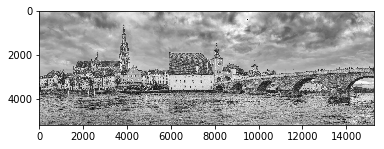

In [5]:
img = mpimg.imread('image/city.jpg')

robot = rgb2gray(img)

robot = robot.astype(np.uint8)

plt.imshow(robot, cmap = 'gray')

In [6]:
def image():
    img = mpimg.imread('image/city.jpg')
    image = rgb2gray(img)
    image = image.astype(np.uint8)
    return image


def split(nbSlice, height, pos, input_array):
    if pos == 1 :
        res = input_array[:(height/nbSlice)+1, :]
    elif pos == nbSlice :
        res = input_array[((height/nbSlice)*(nbSlice-1))-1:, :] 
    else :
        res = input_array[((height/nbSlice)*(pos-1))-1:((height/nbSlice)*(pos))+1, :]
    return res

def resize(nbSlice, height, pos, input_array):
    if pos == 1 :
        res = input_array[:(height/nbSlice), :]
    elif pos == nbSlice :
        res = input_array[1:, :] 
    else :
        res = input_array[1:(height/nbSlice)+1, :]
    return res

In [ ]:
def sobel2(width, height, input_array):
    _lib = ct.CDLL("/home/amonot/Bureau/stageAlex/sobel/sobel.so")
    _lib.sobel.argtypes = [ct.c_int, ct.c_int, array_matrice, array_matrice] 
    output_array = np.zeros((height,width), dtype=np.ubyte)
    _lib.sobel(width, height, input_array, output_array)
    sleep(3)
    return output_array 

In [7]:
#split
robot = dask.delayed(robot)

totalNbSlice = 8
height = 5198
width = 15276
#1024
#1280

#robot000 = split(totalNbSlice, height, 1, robot)
#robot001 = split(totalNbSlice, height, 2, robot)
#robot010 = split(totalNbSlice, height, 3, robot)
#robot011 = split(totalNbSlice, height, 4, robot)
#robot100 = split(totalNbSlice, height, 5, robot)
#robot101 = split(totalNbSlice, height, 6, robot)
#robot110 = split(totalNbSlice, height, 7, robot)
#robot111 = split(totalNbSlice, height, 8, robot)

robot000 = dask.delayed(split)(totalNbSlice, height, 1, robot)
robot001 = dask.delayed(split)(totalNbSlice, height, 2, robot)
robot010 = dask.delayed(split)(totalNbSlice, height, 3, robot)
robot011 = dask.delayed(split)(totalNbSlice, height, 4, robot)
robot100 = dask.delayed(split)(totalNbSlice, height, 5, robot)
robot101 = dask.delayed(split)(totalNbSlice, height, 6, robot)
robot110 = dask.delayed(split)(totalNbSlice, height, 7, robot)
robot111 = dask.delayed(split)(totalNbSlice, height, 8, robot)


In [8]:
result_sobel000 = dask.delayed(sobel)(width, (height/totalNbSlice)+1, robot000)
result_sobel001 = dask.delayed(sobel)(width, (height/totalNbSlice)+2, robot001)
result_sobel010 = dask.delayed(sobel)(width, (height/totalNbSlice)+2, robot010)
result_sobel011 = dask.delayed(sobel)(width, (height/totalNbSlice)+2, robot011)
result_sobel100 = dask.delayed(sobel)(width, (height/totalNbSlice)+2, robot100)
result_sobel101 = dask.delayed(sobel)(width, (height/totalNbSlice)+2, robot101)
result_sobel110 = dask.delayed(sobel)(width, (height/totalNbSlice)+2, robot110)
result_sobel111 = dask.delayed(sobel)(width, (height/totalNbSlice)+1, robot111)

In [9]:
result_Dask_slice0 = dask.delayed(resize)(totalNbSlice, height, 1, result_sobel000)
result_Dask_slice1 = dask.delayed(resize)(totalNbSlice, height, 2, result_sobel001)
result_Dask_slice2 = dask.delayed(resize)(totalNbSlice, height, 3, result_sobel010)
result_Dask_slice3 = dask.delayed(resize)(totalNbSlice, height, 4, result_sobel011)
result_Dask_slice4 = dask.delayed(resize)(totalNbSlice, height, 5, result_sobel100)
result_Dask_slice5 = dask.delayed(resize)(totalNbSlice, height, 6, result_sobel101)
result_Dask_slice6 = dask.delayed(resize)(totalNbSlice, height, 7, result_sobel110)
result_Dask_slice7 = dask.delayed(resize)(totalNbSlice, height, 8, result_sobel111)

In [10]:
# result = np.zeros((1024,1280), dtype=np.ubyte)


In [11]:
data = [[result_Dask_slice0],
        [result_Dask_slice1],
        [result_Dask_slice2], 
        [result_Dask_slice3],
        [result_Dask_slice4],
        [result_Dask_slice5],
        [result_Dask_slice6],
        [result_Dask_slice7]]
result_Dask_slices = dask.delayed(da.block)(data)

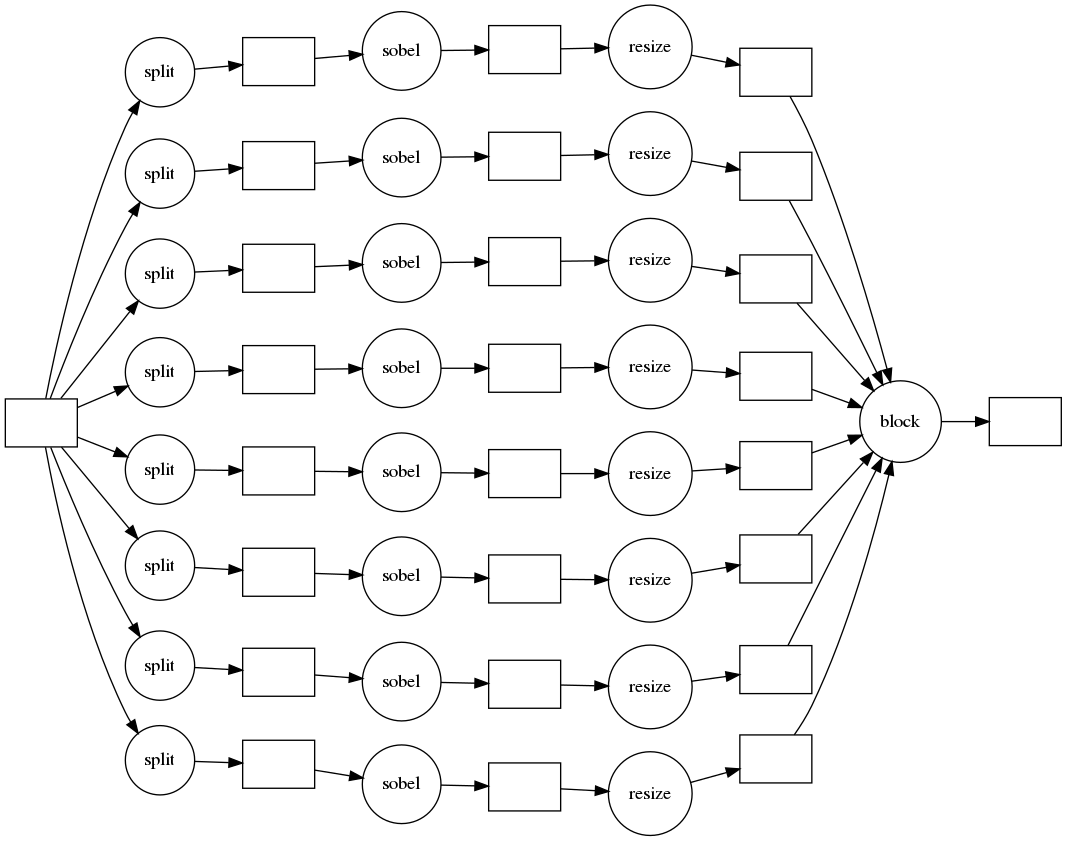

In [12]:
result_Dask_slices.visualize(rankdir='LR')

In [13]:
graph = result_Dask_slices.__dask_graph__()

In [ ]:
graph.layers

In [ ]:
df

In [ ]:
from dask.multiprocessing import get
get(graph,'block-e0d4be71-3b0a-47ce-a80b-e010e96171fb')

In [ ]:
file1 = open("graph.txt","w") 
file1.write(repr(graph.layers))
file1.close() 

In [14]:
%time array = result_Dask_slices.compute()
#%time array = result_Dask_slices.compute(scheduler='processes')
#%time array = result_Dask_slices.compute(scheduler='single-threaded')


CPU times: user 854 ms, sys: 345 ms, total: 1.2 s
Wall time: 2.63 s


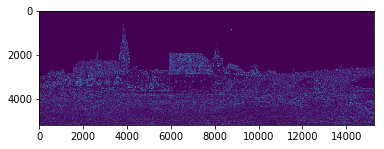

In [15]:
plt.imshow(array)
plt.imsave("test.jpg",array)

In [ ]:
array.shape

In [ ]:
%time dask.compute(result_sobel000,result_sobel001,result_sobel010,result_sobel011,result_sobel100,result_sobel101,result_sobel110,result_sobel111)

In [ ]:
result_sobel = dask.delayed(sobel)(width, height, robot)

In [ ]:
%time result_sobel.compute()

In [ ]:
df = {'block-e0d4be71-3b0a-47ce-a80b-e010e96171fb': {'block-e0d4be71-3b0a-47ce-a80b-e010e96171fb': (da.block,
   [['resize-0b218975-d9b3-4284-a969-8b1bc1c036c0'],
    ['resize-4687cdf1-30fe-4bb5-a157-f9bb2a79738a'],
    ['resize-318da62d-7385-4403-ab50-93ab18af6fd0'],
    ['resize-2b74be16-6eeb-4de2-a324-ed785d9a0164'],
    ['resize-2ffa8727-0d4a-4b17-96ab-d6e54df5cfd6'],
    ['resize-54582654-9759-4814-a342-033e5ad56b03'],
    ['resize-09620525-25c1-4736-bb60-1e3c2906fc35'],
    ['resize-bdd64a9a-b933-4147-bf00-00e8ccb944c6']])},
 'ndarray-dbae0d5c-d15a-4b21-ac8c-973bbbc4236b': robot,
 'resize-09620525-25c1-4736-bb60-1e3c2906fc35': {'resize-09620525-25c1-4736-bb60-1e3c2906fc35': (resize,
   8,
   5198,
   7,
   'sobel-51ecd711-c265-45d2-8476-e1bbbe78a7cd')},
 'resize-0b218975-d9b3-4284-a969-8b1bc1c036c0': {'resize-0b218975-d9b3-4284-a969-8b1bc1c036c0': (resize,
   8,
   5198,
   1,
   'sobel-cffc7532-a990-41ee-acfa-6e72814f2806')},
 'resize-2b74be16-6eeb-4de2-a324-ed785d9a0164': {'resize-2b74be16-6eeb-4de2-a324-ed785d9a0164': (resize,
   8,
   5198,
   4,
   'sobel-c317f072-5351-453e-a288-513dbfc43eaf')},
 'resize-2ffa8727-0d4a-4b17-96ab-d6e54df5cfd6': {'resize-2ffa8727-0d4a-4b17-96ab-d6e54df5cfd6': (resize,
   8,
   5198,
   5,
   'sobel-779739b5-864b-4967-a2c5-a6ef49239b25')},
 'resize-318da62d-7385-4403-ab50-93ab18af6fd0': {'resize-318da62d-7385-4403-ab50-93ab18af6fd0': (resize,
   8,
   5198,
   3,
   'sobel-01f98889-20fd-4832-b0d0-6546414c34fd')},
 'resize-4687cdf1-30fe-4bb5-a157-f9bb2a79738a': {'resize-4687cdf1-30fe-4bb5-a157-f9bb2a79738a': (resize,
   8,
   5198,
   2,
   'sobel-88fae7d1-690a-4361-bf16-ccdcafb3d235')},
 'resize-54582654-9759-4814-a342-033e5ad56b03': {'resize-54582654-9759-4814-a342-033e5ad56b03': (resize,
   8,
   5198,
   6,
   'sobel-eb0b3123-f617-453e-8539-0e2c17ab66ed')},
 'resize-bdd64a9a-b933-4147-bf00-00e8ccb944c6': {'resize-bdd64a9a-b933-4147-bf00-00e8ccb944c6': (resize,
   8,
   5198,
   8,
   'sobel-c544fd6c-98bf-4972-a6f7-49d42c4c5d46')},
 'sobel-01f98889-20fd-4832-b0d0-6546414c34fd': {'sobel-01f98889-20fd-4832-b0d0-6546414c34fd': (sobel,
   15276,
   651,
   'split-e50503a7-41cc-41d0-8917-440352994f61')},
 'sobel-51ecd711-c265-45d2-8476-e1bbbe78a7cd': {'sobel-51ecd711-c265-45d2-8476-e1bbbe78a7cd': (sobel,
   15276,
   651,
   'split-43f8e92c-da35-4dff-9931-0f99b66eac2c')},
 'sobel-779739b5-864b-4967-a2c5-a6ef49239b25': {'sobel-779739b5-864b-4967-a2c5-a6ef49239b25': (sobel,
   15276,
   651,
   'split-1bef90e8-97a4-4ae6-a3f3-6e73b00aa64b')},
 'sobel-88fae7d1-690a-4361-bf16-ccdcafb3d235': {'sobel-88fae7d1-690a-4361-bf16-ccdcafb3d235': (sobel,
   15276,
   651,
   'split-505ca263-33a0-444c-ab64-3a4192aa6ee6')},
 'sobel-c317f072-5351-453e-a288-513dbfc43eaf': {'sobel-c317f072-5351-453e-a288-513dbfc43eaf': (sobel,
   15276,
   651,
   'split-2957425c-8e7c-4b40-9fde-c1c4851a5e86')},
 'sobel-c544fd6c-98bf-4972-a6f7-49d42c4c5d46': {'sobel-c544fd6c-98bf-4972-a6f7-49d42c4c5d46': (sobel,
   15276,
   650,
   'split-a74c1e32-9d6b-4e47-843b-09b17e4709d0')},
 'sobel-cffc7532-a990-41ee-acfa-6e72814f2806': {'sobel-cffc7532-a990-41ee-acfa-6e72814f2806': (sobel,
   15276,
   650,
   'split-c8de7136-4da7-4e4e-8fd6-34b03a3a5523')},
 'sobel-eb0b3123-f617-453e-8539-0e2c17ab66ed': {'sobel-eb0b3123-f617-453e-8539-0e2c17ab66ed': (sobel,
   15276,
   651,
   'split-e8ad0953-b9d6-4c6a-9dbf-35e67110389a')},
 'split-1bef90e8-97a4-4ae6-a3f3-6e73b00aa64b': {'split-1bef90e8-97a4-4ae6-a3f3-6e73b00aa64b': (split,
   8,
   5198,
   5,
   'ndarray-dbae0d5c-d15a-4b21-ac8c-973bbbc4236b')},
 'split-2957425c-8e7c-4b40-9fde-c1c4851a5e86': {'split-2957425c-8e7c-4b40-9fde-c1c4851a5e86': (split,
   8,
   5198,
   4,
   'ndarray-dbae0d5c-d15a-4b21-ac8c-973bbbc4236b')},
 'split-43f8e92c-da35-4dff-9931-0f99b66eac2c': {'split-43f8e92c-da35-4dff-9931-0f99b66eac2c': (split,
   8,
   5198,
   7,
   'ndarray-dbae0d5c-d15a-4b21-ac8c-973bbbc4236b')},
 'split-505ca263-33a0-444c-ab64-3a4192aa6ee6': {'split-505ca263-33a0-444c-ab64-3a4192aa6ee6': (split,
   8,
   5198,
   2,
   'ndarray-dbae0d5c-d15a-4b21-ac8c-973bbbc4236b')},
 'split-a74c1e32-9d6b-4e47-843b-09b17e4709d0': {'split-a74c1e32-9d6b-4e47-843b-09b17e4709d0': (split,
   8,
   5198,
   8,
   'ndarray-dbae0d5c-d15a-4b21-ac8c-973bbbc4236b')},
 'split-c8de7136-4da7-4e4e-8fd6-34b03a3a5523': {'split-c8de7136-4da7-4e4e-8fd6-34b03a3a5523': (split,
   8,
   5198,
   1,
   'ndarray-dbae0d5c-d15a-4b21-ac8c-973bbbc4236b')},
 'split-e50503a7-41cc-41d0-8917-440352994f61': {'split-e50503a7-41cc-41d0-8917-440352994f61': (split,
   8,
   5198,
   3,
   'ndarray-dbae0d5c-d15a-4b21-ac8c-973bbbc4236b')},
 'split-e8ad0953-b9d6-4c6a-9dbf-35e67110389a': {'split-e8ad0953-b9d6-4c6a-9dbf-35e67110389a': (split,
   8,
   5198,
   6,
   'ndarray-dbae0d5c-d15a-4b21-ac8c-973bbbc4236b')}}

In [ ]:
from dask.highlevelgraph import HighLevelGraph

g = HighLevelGraph(df, graph.dependencies)

In [ ]:
from dask.multiprocessing import get
result = get(g, 'block-e0d4be71-3b0a-47ce-a80b-e010e96171fb')

In [ ]:
df = {  'block':(da.block,
   [[('rezize',1)],
    [('rezize',2)],
    [('rezize',3)],
    [('rezize',4)],
    [('rezize',5)],
    [('rezize',6)],
    [('rezize',7)],
    [('rezize',8)]]),
        ('rezize',1):(resize, 8, 5198, 1, ('sobel',1)),
        ('rezize',2):(resize, 8, 5198, 2, ('sobel',2)),
        ('rezize',3):(resize, 8, 5198, 3, ('sobel',3)),
        ('rezize',4):(resize, 8, 5198, 4, ('sobel',4)),
        ('rezize',5):(resize, 8, 5198, 5, ('sobel',5)),
        ('rezize',6):(resize, 8, 5198, 6, ('sobel',6)),
        ('rezize',7):(resize, 8, 5198, 7, ('sobel',7)),
        ('rezize',8):(resize, 8, 5198, 8, ('sobel',8)),
        ('sobel',1):(sobel, 15276, 651, ('split',1)),
        ('sobel',2):(sobel, 15276, 651, ('split',2)),
        ('sobel',3):(sobel, 15276, 651, ('split',3)),
        ('sobel',4):(sobel, 15276, 651, ('split',4)),
        ('sobel',5):(sobel, 15276, 651, ('split',5)),
        ('sobel',6):(sobel, 15276, 651, ('split',6)),
        ('sobel',7):(sobel, 15276, 651, ('split',7)),
        ('sobel',8):(sobel, 15276, 651, ('split',8)),
        ('split',1):(split, 8, 5198, 1, 'array'),
        ('split',2):(split, 8, 5198, 2, 'array'),
        ('split',3):(split, 8, 5198, 3, 'array'),
        ('split',4):(split, 8, 5198, 4, 'array'),
        ('split',5):(split, 8, 5198, 5, 'array'),
        ('split',6):(split, 8, 5198, 6, 'array'),
        ('split',7):(split, 8, 5198, 7, 'array'),
        ('split',8):(split, 8, 5198, 8, 'array'),
        'array':(image,)
}

dependencies = {'array': set(),
                'split': {'array'},
                'sobel': {'split'},
                'rezize': {'sobel'},
                'block': {'rezize'}}

In [ ]:
from dask.highlevelgraph import HighLevelGraph
graph = HighLevelGraph(df, dependencies)

In [ ]:
#import dask.distributed as d
#d.Client.get
result = client.get(df, 'block')
plt.imshow(result)

In [ ]:
result